<a href="https://colab.research.google.com/github/marlonrcfranco/soyforecast/blob/master/soyforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soyforecast
By [Marlon Franco]()
/ [GitHub](https://github.com/marlonrcfranco/soyforecast.git)

####Prediction of future soybeans stock prices on the Chicago Stock Exchange (CBOT) using a LSTM model and relating climatic data from the most productive regions of the USA.

![alt text](https://github.com/marlonrcfranco/soyforecast/blob/master/Selection_244.png?raw=true)


## Soybean, CBOT Soybean Futures + ( Global Historical Climatology Network (GHCN) filtered by USDA-NASS-soybeans-production_bushels-2015)

### Soybean, CBOT Soybean Futures
- *https://blog.quandl.com/api-for-commodity-data*
- *http://www.quandl.com/api/v3/datasets/CHRIS/CME_S1/*

### Global Historical Climatology Network (GHCN)
- *https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn*
- *FTP: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/*


- **TMAX** = Maximum temperature (tenths of degrees C)
- **TMIN** = Minimum temperature (tenths of degrees C)
- **TAVG** = Average temperature (tenths of degrees C)
```
(Note that TAVG from source 'S' corresponds to an average for the period ending at 2400 UTC rather than local midnight )
```
- **PRCP** = Precipitation (tenths of mm)

### USDA-NASS-soybeans-production_bushels-2015
- *https://usda-reports.nautilytics.com/?crop=soybeans&statistic=production_dollars&year=2007*
- *https://www.nass.usda.gov/Data_Visualization/index.php*


****

*Based on the tutorial: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/*


## Imports

In [625]:
%matplotlib inline
import os
from six.moves import urllib

from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import matplotlib.pyplot as plt

'''

import matplotlib.ticker as mticker



import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

'''



'\n\nimport matplotlib.ticker as mticker\n\n\n\nimport tensorflow as tf\nfrom sklearn.preprocessing import MinMaxScaler\nfrom tensorflow.python.keras.models import Sequential\nfrom tensorflow.python.keras.layers import Input, Dense, GRU, Embedding\nfrom tensorflow.python.keras.optimizers import RMSprop\nfrom tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau\n\n'

In [582]:
tf.__version__

'1.14.0-rc1'

In [583]:
tf.keras.__version__

'2.2.4-tf'

## Defines

In [0]:
DATASETMARLON_URL = "https://raw.githubusercontent.com/marlonrcfranco/soyforecast/master/datasets/DatasetMarlon/datasetMarlon.csv"
DATASETMARLON_PATH = "datasets/DatasetMarlon/"
SETTLE_id = 5
TARGET_NAME = 'Settle'

START_IDX=0 #Start-index for the time-series.
LENGHT=100000 #Sequence-length to process and plot.

#plt.rcParams["figure.figsize"] = [19,15]
#plt.rcParams.update({'font.size': 27})

## Fetch Data



In [0]:
def fetch_datasetMarlon_data(datasetmarlon_url=DATASETMARLON_URL, datasetmarlon_path=DATASETMARLON_PATH):
    if not os.path.isdir(datasetmarlon_path):
        os.makedirs(datasetmarlon_path)
    csv_path = os.path.join(datasetmarlon_path, "datasetMarlon.csv")
    urllib.request.urlretrieve(datasetmarlon_url, csv_path)

    

In [0]:
fetch_datasetMarlon_data()

## Convert series to supervised learning


In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


## Load Data


In [0]:
def load_datasetMarlon_data(datasetmarlon_path=DATASETMARLON_PATH):
    csv_path = os.path.join(datasetmarlon_path, "datasetMarlon.csv")
    print(csv_path)
    return read_csv(csv_path,index_col=['Date','YEAR','MONTH','DAY'])
 

In [589]:
dataset = load_datasetMarlon_data()
values = dataset.values
print(dataset.shape)
dataset.head(1)

datasets/DatasetMarlon/datasetMarlon.csv
(15062, 256)


,,,,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,TX_TMAX_MEAN,TX_TMAX_STD,TX_TMIN_MEAN,TX_TMIN_STD,TX_TAVG_MEAN,TX_TAVG_STD,TX_PRCP_MEAN,TX_PRCP_STD,NC_TMAX_MEAN,NC_TMAX_STD,NC_TMIN_MEAN,NC_TMIN_STD,NC_TAVG_MEAN,NC_TAVG_STD,NC_PRCP_MEAN,NC_PRCP_STD,NE_TMAX_MEAN,NE_TMAX_STD,NE_TMIN_MEAN,NE_TMIN_STD,NE_TAVG_MEAN,NE_TAVG_STD,NE_PRCP_MEAN,NE_PRCP_STD,KS_TMAX_MEAN,KS_TMAX_STD,KS_TMIN_MEAN,KS_TMIN_STD,KS_TAVG_MEAN,KS_TAVG_STD,KS_PRCP_MEAN,KS_PRCP_STD,...,MS_TMAX_MEAN,MS_TMAX_STD,MS_TMIN_MEAN,MS_TMIN_STD,MS_TAVG_MEAN,MS_TAVG_STD,MS_PRCP_MEAN,MS_PRCP_STD,ND_TMAX_MEAN,ND_TMAX_STD,ND_TMIN_MEAN,ND_TMIN_STD,ND_TAVG_MEAN,ND_TAVG_STD,ND_PRCP_MEAN,ND_PRCP_STD,WV_TMAX_MEAN,WV_TMAX_STD,WV_TMIN_MEAN,WV_TMIN_STD,WV_TAVG_MEAN,WV_TAVG_STD,WV_PRCP_MEAN,WV_PRCP_STD,DE_TMAX_MEAN,DE_TMAX_STD,DE_TMIN_MEAN,DE_TMIN_STD,DE_TAVG_MEAN,DE_TAVG_STD,DE_PRCP_MEAN,DE_PRCP_STD,IA_TMAX_MEAN,IA_TMAX_STD,IA_TMIN_MEAN,IA_TMIN_STD,IA_TAVG_MEAN,IA_TAVG_STD,IA_PRCP_MEAN,IA_PRCP_STD
Date,YEAR,MONTH,DAY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-22,2019,4,22,881.5,883.25,876.25,876.75,3.5,877.0,62527.0,205572.0,72.62779,566.42426,44.583332,354.48105,18.318048,317.19855,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot each column

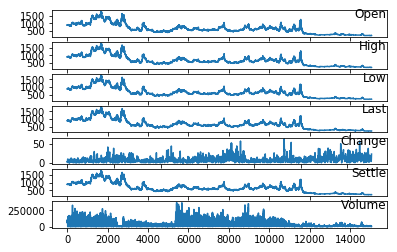

In [590]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

## Integer encode direction

In [0]:
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

## Ensure all data is float


In [0]:
values = values.astype('float32')

## Normalize features

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## Specify the number of lag hours

In [0]:
n_days = 4
n_features = 256

## Frame as supervised learning

In [595]:
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)


(12244, 1280)


## Drop columns we don't want to predict

In [596]:
cols = [reframed.columns.get_loc(col) for col in reframed.columns if reframed.columns.get_loc(col)>=n_days*n_features and reframed.columns.get_loc(col)!=(n_days*n_features+SETTLE_id)]
reframed.drop(reframed.columns[cols], axis=1, inplace=True)
print(reframed.head())

   var1(t-4)  var2(t-4)  var3(t-4)  ...  var255(t-1)  var256(t-1)   var6(t)
5   0.430163   0.431369   0.429128  ...     0.000151     0.002751  0.440987
6   0.435911   0.436790   0.430404  ...     0.024914     0.111334  0.440987
7   0.442617   0.442212   0.435350  ...     0.071050     0.248798  0.445296
8   0.440542   0.444126   0.440775  ...     0.037625     0.254125  0.443221
9   0.440542   0.441893   0.440137  ...     0.000550     0.006923  0.443221

[5 rows x 1025 columns]


## Split into train and test sets

In [0]:
train_split = 0.87

In [598]:
values = reframed.values
num_data = len(values)
num_data

12244

In [599]:
num_train = int(train_split * num_data)
num_train

10652

In [600]:
num_test = num_data - num_train
num_test

1592

In [601]:
train = values[:num_train, :]
test = values[num_train:, :]
len(train) + len(test)

12244

## Split into input and outputs

In [602]:
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

y_train = train_y
y_test = test_y
x_train = train_X
x_test = test_X

print(train_X.shape, len(train_X), train_y.shape)

(10652, 1024) 10652 (10652,)


## Reshape input to be 3D [samples, timesteps, features]

In [603]:
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

y_train_scaled = train_y
x_train_scaled = train_X

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10652, 4, 256) (10652,) (1592, 4, 256) (1592,)


## Design network

In [0]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dense(1, activation='linear'))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mse', optimizer='adam')

## Fit network


In [605]:
%%time
history = model.fit(
    train_X, 
    train_y, 
    epochs=50, 
    batch_size=100, 
    validation_data=(test_X, test_y), 
    verbose=2, 
    shuffle=False)

Train on 10652 samples, validate on 1592 samples
Epoch 1/50
 - 4s - loss: 0.0262 - val_loss: 0.0236
Epoch 2/50
 - 1s - loss: 0.0414 - val_loss: 0.0394
Epoch 3/50
 - 1s - loss: 0.0355 - val_loss: 0.0317
Epoch 4/50
 - 1s - loss: 0.0272 - val_loss: 0.0304
Epoch 5/50
 - 1s - loss: 0.0178 - val_loss: 0.0196
Epoch 6/50
 - 1s - loss: 0.0127 - val_loss: 0.0089
Epoch 7/50
 - 1s - loss: 0.0131 - val_loss: 0.0097
Epoch 8/50
 - 1s - loss: 0.0124 - val_loss: 0.0038
Epoch 9/50
 - 1s - loss: 0.0126 - val_loss: 0.0024
Epoch 10/50
 - 1s - loss: 0.0124 - val_loss: 0.0033
Epoch 11/50
 - 1s - loss: 0.0113 - val_loss: 0.0029
Epoch 12/50
 - 1s - loss: 0.0118 - val_loss: 0.0032
Epoch 13/50
 - 1s - loss: 0.0114 - val_loss: 0.0035
Epoch 14/50
 - 1s - loss: 0.0105 - val_loss: 0.0023
Epoch 15/50
 - 1s - loss: 0.0090 - val_loss: 0.0025
Epoch 16/50
 - 1s - loss: 0.0091 - val_loss: 0.0023
Epoch 17/50
 - 1s - loss: 0.0080 - val_loss: 0.0021
Epoch 18/50
 - 1s - loss: 0.0074 - val_loss: 0.0019
Epoch 19/50
 - 1s - loss

## Plot history

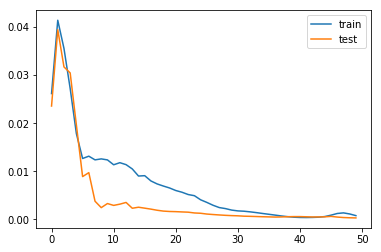

In [606]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Make a prediction

In [0]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

## Invert scaling for forecast

In [0]:
#inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


## Invert scaling for actual

In [0]:
test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

## Calculate RMSE

In [641]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 27.127


## Plot prediction

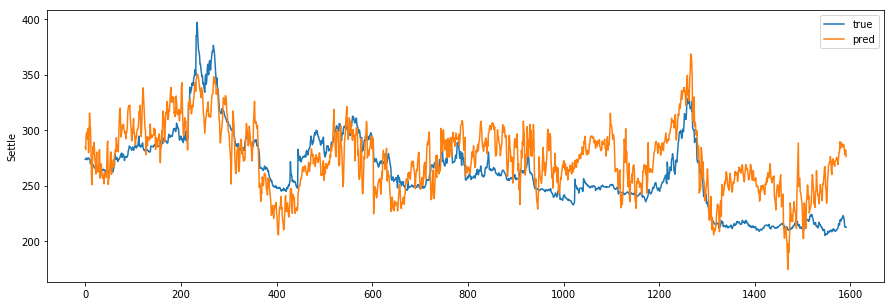

In [642]:
  # Get the output-signal predicted by the model.
  signal_pred = inv_yhat

  # Get the true output-signal from the data-set.
  signal_true = inv_y

  # Make the plotting-canvas bigger.
  plt.figure(figsize=(15,5))

  # Plot and compare the two signals.
  plt.plot(signal_true, label='true')
  plt.plot(signal_pred, label='pred')

  # Plot grey box for warmup-period.
  #p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

  # Plot labels etc.
  plt.ylabel(TARGET_NAME)
  plt.legend()
  plt.show()

## License (MIT)

Copyright (c) 2018 by [Marlon Franco]()

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.